In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import tensorflow as tf

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import AdversarialPatch
import pandas as pd
import os
import cv2
from PIL import Image

In [2]:

    
tf.compat.v1.disable_eager_execution()

In [3]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [4]:
train_path = "data/Train"
test_path = "data/Test"
data_dir = 'data'
# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3
NUM_CATEGORIES = len(os.listdir(train_path))

In [5]:
target_name = 'toaster'
image_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
clip_values = (0, 255)
nb_classes  = len(classes)
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

In [6]:
from keras.models import load_model
model = load_model('models/kaggle_model.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = KerasClassifier(model=model, clip_values=(0, 255))

In [8]:
test = pd.read_csv(os.path.join(data_dir, 'Test.csv'))

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    image = cv2.imread(os.path.join(data_dir, img))
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
    data.append(np.array(resize_image))

In [9]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_shape=(5,5,3),targeted=False)

In [10]:
x=np.array(data)
x.shape

(12630, 30, 30, 3)

In [18]:
label = 14  #stop sign
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
source_data = np.array(data)
y_target = np.tile(y_one_hot, (source_data.shape[0], 1))



In [52]:
patch, patch_mask = ap.generate(x=source_data[:10],y = y_target[:10])

Adversarial Patch Numpy: 100%|██████████| 500/500 [00:27<00:00, 18.50it/s]


In [53]:
y_target.shape

(12630, 43)

In [54]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

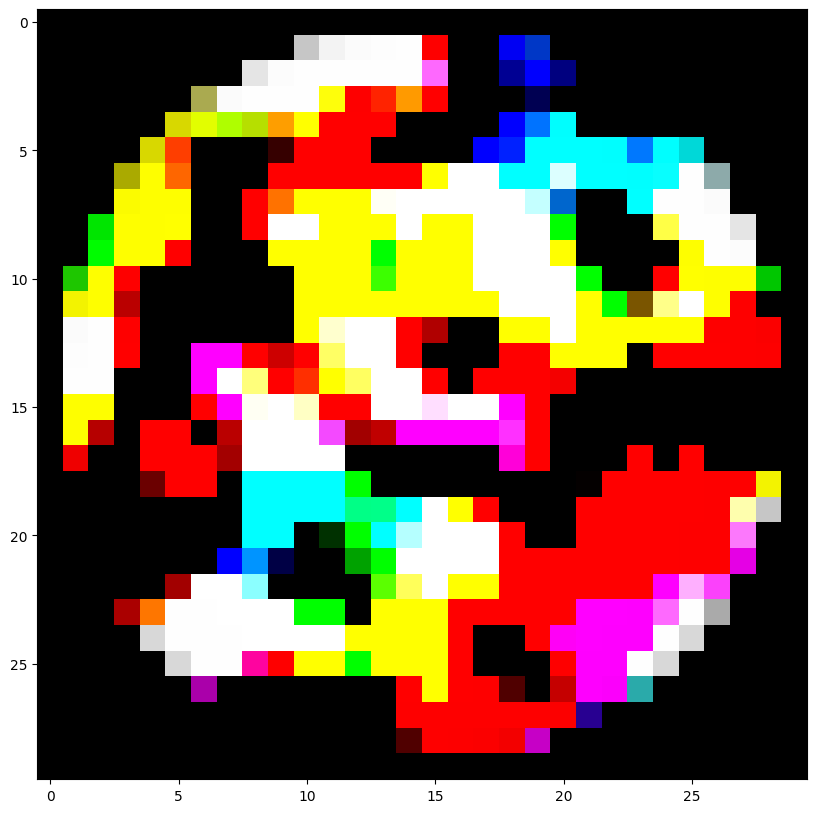

In [55]:
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

##Evaluation

In [56]:
source_data.shape

(12630, 30, 30, 3)

In [57]:
patched_images = ap.apply_patch(source_data,1)

16
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


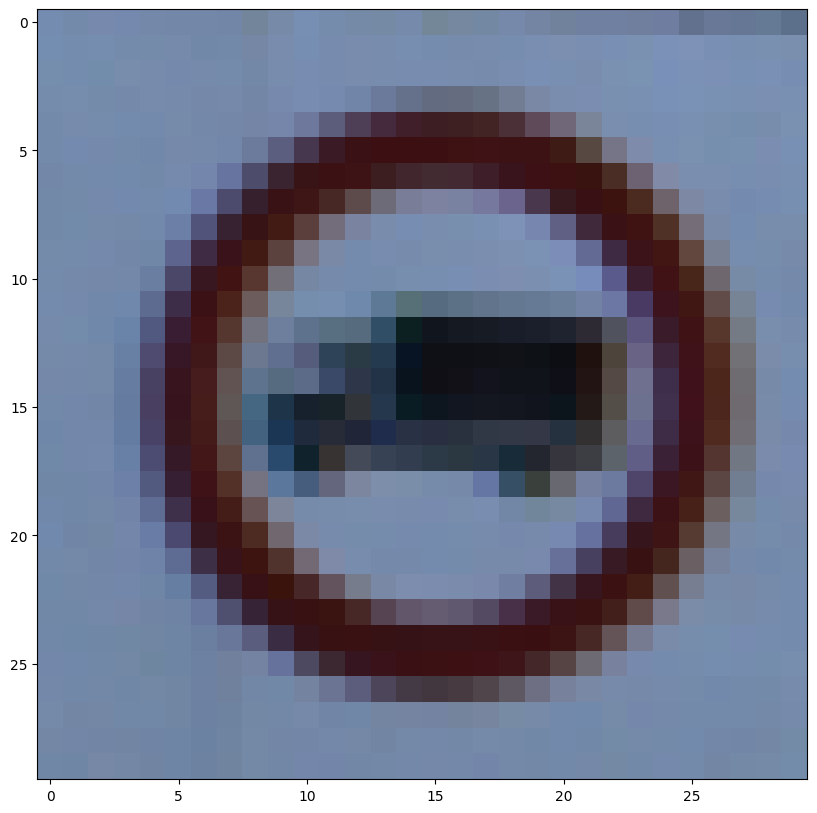

In [58]:
image = source_data[:1]
prediction = tfc.predict(image.astype(np.float32))
print(np.argmax(prediction))
print(prediction)
plt.imshow(bgr_to_rgb(image[0].astype(np.uint8)))
plt.show()



23
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


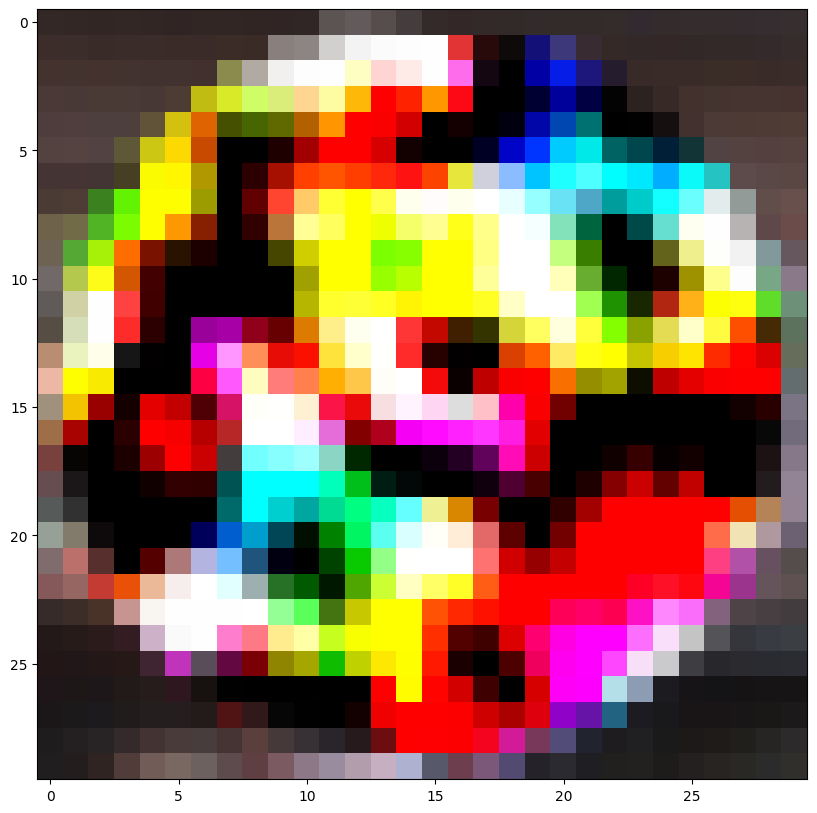

In [59]:
image = patched_images[2:3]
prediction = tfc.predict(image.astype(np.float32))
print(np.argmax(prediction))
print(prediction)
plt.imshow(bgr_to_rgb(image[0].astype(np.uint8)))
plt.show()


In [72]:
def evaluate(classifier, patched_images, target_y):
  predictions = classifier.predict(patched_images.astype(np.float32))
  return [x.all() for x in target_y == predictions]

In [75]:
evaluate(tfc, patched_images, y_target)

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [ ]:
def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)